In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, **customer retention** has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to **predict which customers are at high risk of churn.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
# pd.set_option("max_columns", None) # show all cols
# pd.set_option('max_colwidth', None) # show full width of showing cols
# pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
# pd.options.display.max_seq_items = 200000
# pd.options.display.max_rows = 400000

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data= pd.read_csv('telecom_churn_data.csv')

In [ ]:
data.head()

In [ ]:
data.info()

### Pre-Processing Data

In [ ]:
data.shape

In [ ]:
data.describe()

#### Checking for percentage null values in each column

In [ ]:
null_perc = data.isnull().sum()/data.shape[0]*100
null_perc

### Handling Missing values

In [ ]:
#impute zero in case of missing value actually means zero
recharge_cols = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
                 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
                 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'count_rech_3g_9',
                 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
                 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
data[recharge_cols].describe(include= 'all')

In [ ]:
# It is also observed that the recharge date and the recharge value are missing together which means the customer didn't recharge
data.loc[data.total_rech_data_6.isnull() & data.date_of_last_rech_data_6.isnull(), 
          ["total_rech_data_6", "date_of_last_rech_data_6"]].head()

In [ ]:
data[recharge_cols].min()

In [ ]:
# create a list of recharge columns where we will impute missing values with zeroes i.e. where minimum value is not zero.
zero_impute = ['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9',
        'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9',
        'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9'
       ]

In [ ]:
data[zero_impute]= data[zero_impute].apply(lambda x: x.fillna(0))

data[zero_impute].isnull().sum()

In [ ]:
cat_cols= ['night_pck_user_6','night_pck_user_7','night_pck_user_8','night_pck_user_9',
           'fb_user_6','fb_user_7','fb_user_8','fb_user_9']


In [ ]:
data[cat_cols].describe()

In [ ]:
data[cat_cols]= data[cat_cols].apply(lambda x: x.fillna(-1))
data.shape

In [ ]:
null_perc= data.isnull().sum()/data.shape[0]*100

In [ ]:
# Dropping columns with mor ethan 50% null values
data.drop(data.columns[null_perc>50], axis=1, inplace= True)
data.shape

In [ ]:
# Dropping columns which have same value in every row
for i in data.columns:
    if 'date' in i:
        data.drop(i, axis=1, inplace= True)
data.drop(['circle_id','loc_og_t2o_mou','std_og_t2o_mou','loc_ic_t2o_mou'], axis=1, inplace= True)
data.shape

In [ ]:
null_perc= data.isnull().sum()/data.shape[0]*100
null_value_col_list= list(data.columns[null_perc>0])
null_value_col_list

In [ ]:
#Imputing missing values
for i in null_value_col_list:
    med= data[i].median()
    data[i].fillna(med, inplace= True)
data['onnet_mou_6'].value_counts

In [ ]:
null_perc= data.isnull().sum()/data.shape[0]*100
null_perc

### Filter High value customer

In [ ]:
# Calculate total recharge value in month of June
data['total_rech_data_amt_6']= data['total_rech_data_6']*data['av_rech_amt_data_6']
data['total_rech_6']=data['total_rech_amt_6']+data['total_rech_data_amt_6']

In [ ]:
# Calculate total recharge value in month of July
data['total_rech_data_amt_7']= data['total_rech_data_7']*data['av_rech_amt_data_7']
data['total_rech_7']=data['total_rech_amt_7']+data['total_rech_data_amt_7']

In [ ]:
# Calculate the avg recharge value of June and July
data['av_amt_data_6_7']= (data['total_rech_6']+data['total_rech_7'])/2

In [ ]:
# Calculate the 70th percentile of avg recharge value of June and July
data['av_amt_data_6_7'].describe(percentiles=[0.7])

In [ ]:
data1= data[data['av_amt_data_6_7']> 478]

In [ ]:
print('Before filtering the shape of dataframe is:',data.shape)
print('After filtering the shape of dataframe is:', data1.shape)

In [ ]:
data1.drop(['av_amt_data_6_7','total_rech_data_amt_6','total_rech_6','total_rech_data_amt_7','total_rech_7'], axis=1, inplace= True)
print('After removing the manual columns the shape of dataframe is:', data1.shape)

### Tag churners and remove attributes of the churn phase

In [ ]:
data1['churn']= data['total_ic_mou_9']+data['total_og_mou_9']+data['vol_2g_mb_9']+data['vol_3g_mb_9']
data1['churn'] = data1['churn'].apply(lambda x: 1 if x>0 else 0)

In [ ]:
data1['churn'].describe()

In [ ]:
# change data type to category
data1.churn = data1.churn.astype("category")
# print churn ratio
print("Churn Ratio:",data1.churn.value_counts()*100/data1.shape[0])


In [ ]:
#remove attributes of the churn phase
cat_cols_9=[]
for i in data1.columns:
    if '9' in i:
        data1.drop(i, axis=1, inplace= True)
        if i in cat_cols:
            cat_cols_9.append(i)
            cat_cols.remove(i)

data1.drop('sep_vbc_3g', axis=1, inplace= True)

### Visualization of data

In [ ]:
# change columns types
id_cols= ['mobile_number']
cat_cols.append('churn')

num_cols= [col for col in list(data1.columns) if col not in cat_cols]

num_cols= [col for col in num_cols if col not in id_cols]

data1[num_cols].iloc[0]

data1[num_cols]= data1[num_cols].apply(pd.to_numeric)

data1[cat_cols] = data1[cat_cols].apply(lambda column: column.astype("category"), axis=0)

In [53]:
# create plotting functions
def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def univariate(variable, stats=True):
    
    if data_type(variable) == 'numerical':
        sns.displot(variable)
        if stats == True:
            print(variable.describe())
    
    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")
        
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(x= var1, y= var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(x= var1, y= var2)

### Univariate EDA

In [ ]:
univariate(data1.arpu_6)
univariate(data1.loc_og_t2t_mou_6)
univariate(data1.std_og_mou_6)
univariate(data1.onnet_mou_6)
univariate(data1.offnet_mou_6)

As we can observe all the Variables are very <b>Skewed</b> towards the left

### Bivariate Analysis

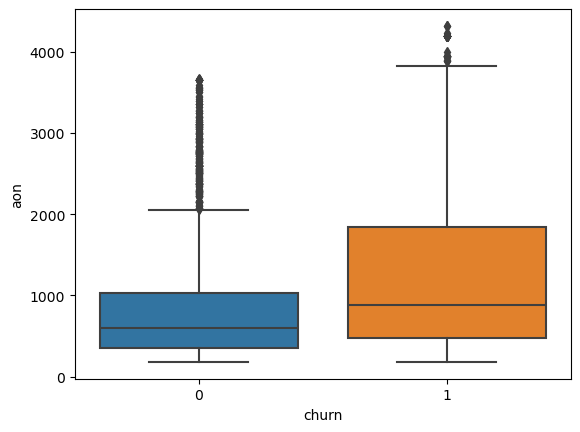

In [54]:
bivariate(data1.churn, data1.aon)

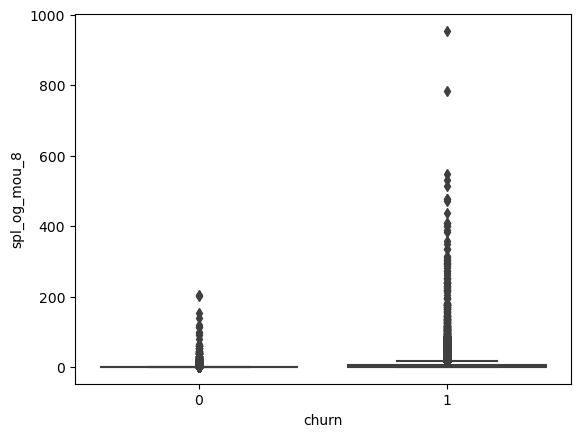

In [56]:
bivariate( data1.churn, data1.spl_og_mou_8)

In [57]:
pd.crosstab(data1.churn, data1.night_pck_user_8, normalize='columns')*100

night_pck_user_8,-1.0,0.0,1.0
churn,,,
0,14.081895,2.885725,2.639296
1,85.918105,97.114275,97.360704


In [58]:
pd.crosstab(data1.churn, data1.sachet_3g_8)

sachet_3g_8,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,25,27,29,30,38,41
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2361,48,5,8,4,2,1,0,2,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,24936,1608,397,183,106,86,43,35,28,19,15,8,11,10,6,6,2,2,3,1,3,3,2,1,1,1,2,1,1


In [59]:
#Checking for columns with zero variance and single value throughout
for i in data1.columns:
    if len(pd.value_counts(data1[i]).unique())==1:
        print(i)

mobile_number
std_og_t2c_mou_6
std_og_t2c_mou_7
std_og_t2c_mou_8
std_ic_t2o_mou_6
std_ic_t2o_mou_7
std_ic_t2o_mou_8


In [60]:
data1.drop(['std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8'],
           axis=1, inplace= True)

In [61]:
remove_col=['std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']
for i in remove_col:
    num_cols.remove(i)

In [62]:
data1.shape

(29953, 141)

### Capping the outliers using k-sigma technique

In [63]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [64]:
# example of capping
sample_array = list(range(100))

# add outliers to the data
sample_array[0] = -9999
sample_array[99] = 9999

# cap outliers
sample_array = np.array(sample_array)
print("Array after capping outliers: \n", cap_outliers(sample_array, k=2))

Array after capping outliers: 
 [-2780     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19    20    21    22    23
    24    25    26    27    28    29    30    31    32    33    34    35
    36    37    38    39    40    41    42    43    44    45    46    47
    48    49    50    51    52    53    54    55    56    57    58    59
    60    61    62    63    64    65    66    67    68    69    70    71
    72    73    74    75    76    77    78    79    80    81    82    83
    84    85    86    87    88    89    90    91    92    93    94    95
    96    97    98  2877]


In [65]:
# cap outliers in the numeric columns
data1[num_cols] = data1[num_cols].apply(cap_outliers, axis=0)

In [66]:
data1.shape

(29953, 141)

### Modelling

In [67]:
# import required libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from imblearn.metrics import sensitivity_specificity_support
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [68]:
# change churn to numeric
data1['churn'] = pd.to_numeric(data1['churn'])

### Train - Test Split

In [70]:
# divide data into train and test
X = data1.drop("churn", axis = 1)
y = data1.churn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4, stratify = y)

In [71]:
# print shapes of train and test sets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22464, 140)
(22464,)
(7489, 140)
(7489,)


### Aggregating the categorical columns

In [72]:
train = pd.concat([X_train, y_train], axis=1)

# aggregate the categorical variables
print(train.groupby('night_pck_user_6').churn.mean())
print(train.groupby('night_pck_user_7').churn.mean())
print(train.groupby('night_pck_user_8').churn.mean())
print(train.groupby('fb_user_6').churn.mean())
print(train.groupby('fb_user_7').churn.mean())
print(train.groupby('fb_user_8').churn.mean())

night_pck_user_6
-1.0    0.902545
0.0     0.932158
1.0     0.907348
Name: churn, dtype: float64
night_pck_user_7
-1.0    0.886385
0.0     0.943441
1.0     0.934066
Name: churn, dtype: float64
night_pck_user_8
-1.0    0.859641
0.0     0.970825
1.0     0.972332
Name: churn, dtype: float64
fb_user_6
-1.0    0.902545
0.0     0.922432
1.0     0.932288
Name: churn, dtype: float64
fb_user_7
-1.0    0.886385
0.0     0.936170
1.0     0.943863
Name: churn, dtype: float64
fb_user_8
-1.0    0.859641
0.0     0.934641
1.0     0.974993
Name: churn, dtype: float64


In [73]:
# replace categories with aggregated values in each categorical column
mapping = {'night_pck_user_6' : {-1.0:0.902545,0.0:0.932158,1.0: 0.907348},
           'night_pck_user_7' : {-1.0: 0.886385,0.0:0.943441,1.0:0.934066},
           'night_pck_user_8' : {-1.0:0.859641,0.0:0.970825,1.0:0.972332},
           'fb_user_6'        : {-1.0:0.902545,0.0:0.922432,1.0:0.932288},
           'fb_user_7'        : {-1.0:0.886385,0.0:0.936170,1.0 : 0.943863},
           'fb_user_8'        : {-1.0:0.859641,0.0:0.934641,1.0: 0.974993}
          }
X_train.replace(mapping, inplace = True)
X_test.replace(mapping, inplace = True)

In [74]:
# check data type of categorical columns - make sure they are numeric
X_train[[col for col in cat_cols if col not in ['churn']]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22464 entries, 93337 to 75657
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   night_pck_user_6  22464 non-null  category
 1   night_pck_user_7  22464 non-null  category
 2   night_pck_user_8  22464 non-null  category
 3   fb_user_6         22464 non-null  category
 4   fb_user_7         22464 non-null  category
 5   fb_user_8         22464 non-null  category
dtypes: category(6)
memory usage: 307.9 KB


## PCA

In [75]:
# apply pca to train data
pca = Pipeline([('scaler', StandardScaler()), ('pca', PCA())])

In [76]:
pca.fit(X_train)
churn_pca = pca.fit_transform(X_train)

In [77]:
# extract pca model from pipeline
pca = pca.named_steps['pca']

# look at explainded variance of PCA components
print(pd.Series(np.round(pca.explained_variance_ratio_.cumsum(), 4)*100))

0       13.27
1       24.12
2       30.35
3       35.30
4       39.59
5       42.74
6       45.42
7       47.93
8       50.42
9       52.67
10      54.80
11      56.79
12      58.65
13      60.36
14      61.93
15      63.44
16      64.81
17      66.14
18      67.41
19      68.65
20      69.72
21      70.77
22      71.79
23      72.77
24      73.71
25      74.61
26      75.48
27      76.32
28      77.16
29      77.95
30      78.71
31      79.46
32      80.18
33      80.82
34      81.45
35      82.07
36      82.67
37      83.24
38      83.80
39      84.35
40      84.87
41      85.38
42      85.86
43      86.34
44      86.81
45      87.27
46      87.71
47      88.14
48      88.55
49      88.94
50      89.32
51      89.71
52      90.08
53      90.45
54      90.80
55      91.14
56      91.46
57      91.78
58      92.09
59      92.38
60      92.64
61      92.91
62      93.16
63      93.42
64      93.67
65      93.91
66      94.14
67      94.36
68      94.58
69      94.79
70      95.00
71    

~ 60 components explain 92% variance

~ 80 components explain 97% variance

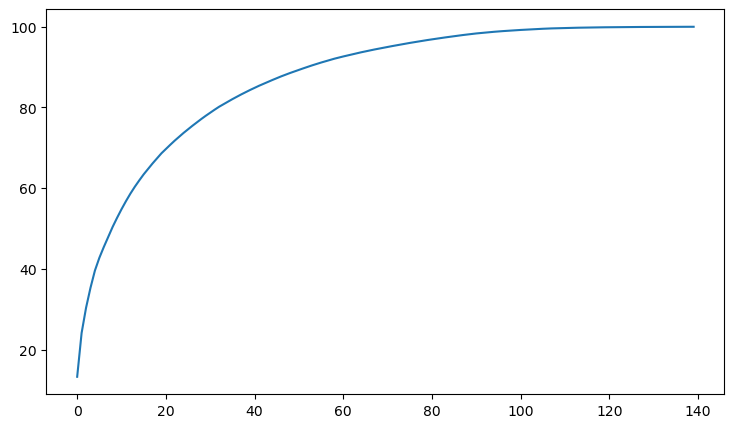

In [78]:
# plot feature variance
features = range(pca.n_components_)
cumulative_variance = np.round(np.cumsum(pca.explained_variance_ratio_)*100, decimals=4)
plt.figure(figsize=(175/20,100/20)) # 100 elements on y-axis; 175 elements on x-axis; 20 is normalising factor
plt.plot(cumulative_variance)

### PCA and Logistic Regression

In [79]:
# create pipeline
PCA_VARS = 60
steps = [('scaler', StandardScaler()),
         ("pca", PCA(n_components=PCA_VARS)),
         ("logistic", LogisticRegression(class_weight='balanced'))
        ]
pipeline = Pipeline(steps)

In [80]:
# fit model
pipeline.fit(X_train, y_train)

# check score on train data
pipeline.score(X_train, y_train)

0.8197560541310541

### Evaluate Model on Test data

In [81]:
# predict churn on test data
y_pred = pipeline.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[ 495  113]
 [1253 5628]]
Sensitivity: 	0.82
Specificity: 	0.81
AUC:    	 0.89


### Hyperparameter Tuning- PCA and Logistic Regression

In [82]:
# class imbalance
y_train.value_counts()/y_train.shape

churn
1    0.918759
0    0.081241
Name: count, dtype: float64

In [83]:
# PCA
pca = PCA()

# logistic regression - the class weight is used to handle class imbalance - it adjusts the cost function
logistic = LogisticRegression(class_weight={0:0.1, 1: 0.9})

# create pipeline
steps = [("scaler", StandardScaler()), 
         ("pca", pca),
         ("logistic", logistic)
        ]

# compile pipeline
pca_logistic = Pipeline(steps)

# hyperparameter space
params = {'pca__n_components': [60, 80], 'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10], 'logistic__penalty': ['l1', 'l2']}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=pca_logistic, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [84]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 0.1,
                                                                         1: 0.9}))]),
             n_jobs=-1,
             param_grid={'logistic__C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                         'logistic__penalty': ['l1', 'l2'],
                         'pca__n_components': [60, 80]},
             scoring='roc_auc', verbose=1)

In [ ]:
# cross validation results
pd.DataFrame(model.cv_results_)

In [86]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.8844634008465272
Best hyperparameters:  {'logistic__C': 1, 'logistic__penalty': 'l2', 'pca__n_components': 80}


In [87]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[   5  603]
 [   0 6881]]
Sensitivity: 	1.0
Specificity: 	0.01
AUC:    	 0.88


## Random Forest Model

In [88]:
# random forest - the class weight is used to handle class imbalance - it adjusts the cost function
forest = RandomForestClassifier(class_weight={0:0.1, 1: 0.9}, n_jobs = -1)

# hyperparameter space
params = {"criterion": ['gini', 'entropy'], "max_features": ['auto', 0.4]}

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

# create gridsearch object
model = GridSearchCV(estimator=forest, cv=folds, param_grid=params, scoring='roc_auc', n_jobs=-1, verbose=1)

In [89]:
# fit model
model.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value f

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
             estimator=RandomForestClassifier(class_weight={0: 0.1, 1: 0.9},
                                              n_jobs=-1),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 0.4]},
             scoring='roc_auc', verbose=1)

In [90]:
# print best hyperparameters
print("Best AUC: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best AUC:  0.924962663254405
Best hyperparameters:  {'criterion': 'entropy', 'max_features': 0.4}


In [91]:
# predict churn on test data
y_pred = model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = model.predict_proba(X_test)[:, 1]
print("AUC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[ 300  308]
 [ 109 6772]]
Sensitivity: 	0.98
Specificity: 	0.49
AUC:    	 0.92


Poor sensitivity. The best model is PCA along with Logistic regression.

### Choosing Best Features

In [92]:
# run a random forest model on train data
max_features = int(round(np.sqrt(X_train.shape[1])))    # number of variables to consider to split each node
print(max_features)

rf_model = RandomForestClassifier(n_estimators=100, max_features=max_features, class_weight={0:0.1, 1: 0.9}, oob_score=True, random_state=4, verbose=1)

12


In [93]:
# fit model
rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   14.3s finished


RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_features=12,
                       oob_score=True, random_state=4, verbose=1)

In [94]:
# OOB score
rf_model.oob_score_

0.9422631766381766

In [95]:
# predict churn on test data
y_pred = rf_model.predict(X_test)

# create onfusion matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# check sensitivity and specificity
sensitivity, specificity, _ = sensitivity_specificity_support(y_test, y_pred, average='binary')
print("Sensitivity: \t", round(sensitivity, 2), "\n", "Specificity: \t", round(specificity, 2), sep='')

# check area under curve
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
print("ROC:    \t", round(roc_auc_score(y_test, y_pred_prob),2))

[[ 285  323]
 [  96 6785]]
Sensitivity: 	0.99
Specificity: 	0.47
ROC:    	 0.91


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


### Features Importance

In [96]:
# predictors
features = data1.drop('churn', axis=1).columns

# feature_importance
importance = rf_model.feature_importances_

# create dataframe
feature_importance = pd.DataFrame({'variables': features, 'importance_percentage': importance*100})
feature_importance = feature_importance[['variables', 'importance_percentage']]

# sort features
feature_importance = feature_importance.sort_values('importance_percentage', ascending=False).reset_index(drop=True)
print("Sum of importance=", feature_importance.importance_percentage.sum())
feature_importance

Sum of importance= 100.0


,variables,importance_percentage
0,total_ic_mou_8,2.380546
1,arpu_8,2.179285
2,arpu_6,1.837495
3,aon,1.763496
4,total_rech_amt_6,1.755491
5,mobile_number,1.724939
6,total_rech_num_6,1.668560
7,total_og_mou_8,1.644442
8,total_rech_amt_8,1.570563
9,arpu_7,1.476627


### Extracting Top 30 Features

In [97]:
# extract top 'n' features
top_n = 30
top_features = feature_importance.variables[0:top_n]
top_features

0       total_ic_mou_8
1               arpu_8
2               arpu_6
3                  aon
4     total_rech_amt_6
5        mobile_number
6     total_rech_num_6
7       total_og_mou_8
8     total_rech_amt_8
9               arpu_7
10    total_rech_num_8
11        loc_ic_mou_6
12    total_rech_num_7
13    loc_ic_t2m_mou_6
14      total_ic_mou_6
15        offnet_mou_6
16      max_rech_amt_8
17    total_rech_amt_7
18      total_og_mou_6
19        offnet_mou_7
20        loc_ic_mou_8
21        offnet_mou_8
22    std_ic_t2t_mou_6
23      total_ic_mou_7
24    loc_ic_t2t_mou_6
25         onnet_mou_6
26      total_og_mou_7
27        std_ic_mou_6
28         onnet_mou_8
29        std_og_mou_6
Name: variables, dtype: object

<Axes: >

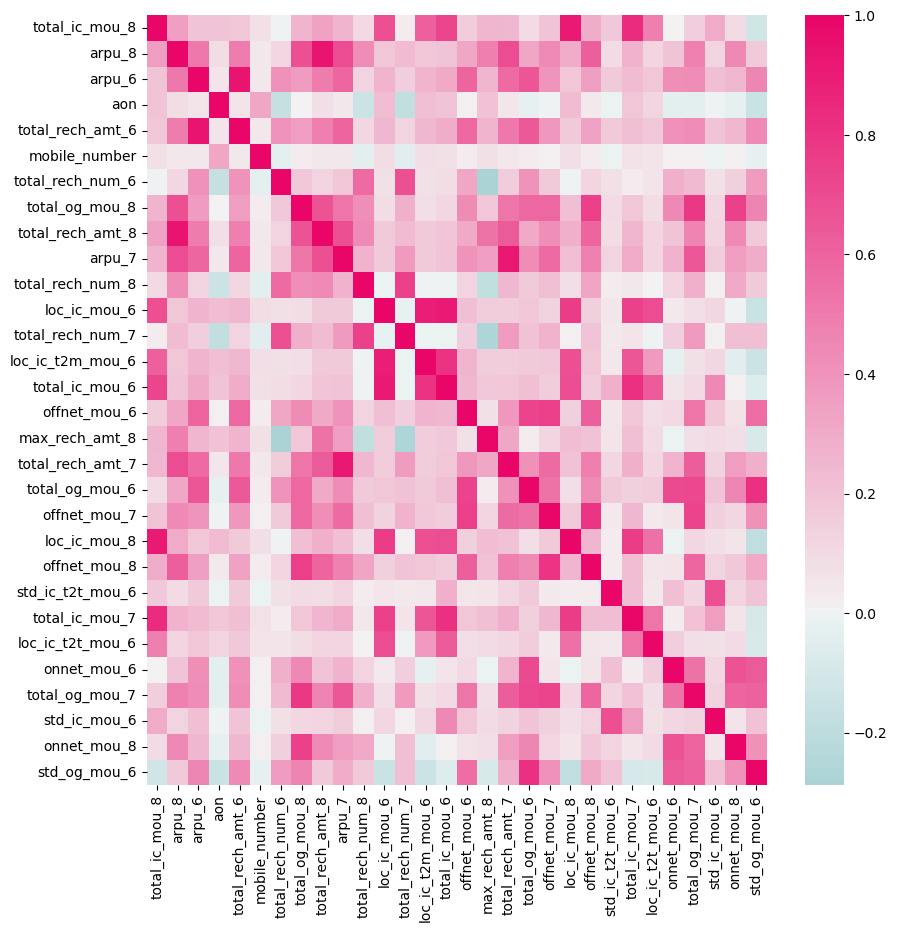

In [98]:
# plot feature correlation
import seaborn as sns
plt.rcParams["figure.figsize"] =(10,10)
mycmap = sns.diverging_palette(199, 359, s=99, center="light", as_cmap=True)
sns.heatmap(data=X_train[top_features].corr(), center=0.0, cmap=mycmap)